* Import Libraries

In [3]:
import glob
import os

import random
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

## Mean/Std of Dataset

In [13]:
sum_r, sum_g, sum_b = 0.0, 0.0, 0.0
sum_sq_r, sum_sq_g, sum_sq_b = 0.0, 0.0, 0.0
total_pixels = 0
total_img = 0

dataset_dir = 'Dataset'

In [14]:
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        total_img += len(os.listdir(class_path))

Progress_bar = tqdm(total=total_img, desc="Processing Images", unit="img")
print(f"Total number of images: {total_img}")

Processing Images:   0%|          | 0/6840 [00:00<?, ?img/s]

Total number of images: 6840


In [15]:
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load: {img_path}")
            Progress_bar.update(1)
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        
        sum_r += np.sum(img[:, :, 0])
        sum_g += np.sum(img[:, :, 1])
        sum_b += np.sum(img[:, :, 2])
        
        sum_sq_r += np.sum(img[:, :, 0] ** 2)
        sum_sq_g += np.sum(img[:, :, 1] ** 2)
        sum_sq_b += np.sum(img[:, :, 2] ** 2)
        
        total_pixels += img.shape[0] * img.shape[1]
        Progress_bar.update(1)
        
Progress_bar.close()

Processing Images: 100%|██████████| 6840/6840 [04:47<00:00, 23.80img/s]


In [23]:
mean_r = sum_r / total_pixels
mean_g = sum_g / total_pixels
mean_b = sum_b / total_pixels

std_r = np.sqrt((sum_sq_r / total_pixels) - (mean_r ** 2))
std_g = np.sqrt((sum_sq_g / total_pixels) - (mean_g ** 2))
std_b = np.sqrt((sum_sq_b / total_pixels) - (mean_b ** 2))

mean = [mean_r / 255, mean_g / 255, mean_b / 255]
std = [std_r / 255, std_g / 255, std_b / 255]

dataset_mean = [round(float(i), 4) for i in mean]
dataset_std = [round(float(j), 4) for j in std]

print(f"Dataset Mean (RGB): {dataset_mean}")
print(f"Dataset Std (RGB): {dataset_std}")

Dataset Mean (RGB): [0.5712, 0.5744, 0.6054]
Dataset Std (RGB): [0.1176, 0.1234, 0.12]


In [4]:
dataset_mean = [0.5712, 0.5744, 0.6054]
dataset_std = [0.1176, 0.1234, 0.12]

## Transform

In [ ]:
transform_Album = A.Compose(
    [   
        A.Resize(256, 256),
        A.Affine(
            translate_percent=0.03,
            scale=(0.97, 1.03),
            rotate=(-10, 10),
            fill=0,
            p=0.4
        ),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            fill=0,
            p=0.4
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.1,
            contrast_limit=0.1,
            p=0.4
        ),
        A.RGBShift(
          r_shift_limit=5,
          g_shift_limit=5,
          b_shift_limit=5,
          p=0.4 
        ),
        A.Blur(
            blur_limit=2,
            p=0.2
        ),
        A.GaussNoise(
            std_range=(0.01, 0.05),
            p=0.2
        ),
        A.CoarseDropout(
            num_holes_range=(6, 8),
            hole_height_range=(4, 8),
            hole_width_range=(4, 8),
            fill=0,
            p=0.5
        ),
        A.Normalize(
            mean=dataset_mean,
            std=dataset_std   
        ),
        ToTensorV2()
    ],
    p=1
)

In [19]:
transform_Simple = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

## Traffic Sign Dataset

In [6]:
root_dir = "TestDB"
images_path_list = []
labels_path_list = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [7]:
class_idx

{0: 'barred_area',
 1: 'cross_walk',
 2: 'go_straight',
 3: 'no_passing_zone_beginning',
 4: 'parking_zone',
 5: 'priority_over',
 6: 'steep_hill_downhill',
 7: 'steep_hill_uphill',
 8: 'stop',
 9: 'tunnel_beginning',
 10: 'turn_left',
 11: 'turn_right'}

In [25]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            if isinstance(self.transform, A.Compose):
                # Albumentations
                augmented = self.transform(image=image)
                image = augmented["image"]
            else:
                # PyTorch
                image = Image.open(path).convert("RGB")
                image = self.transform(image)
        else:
            image = ToTensorV2()(image=image)["image"]
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [29]:
trafficSign = TrafficSignDB(
    images_path_list=images_path_list,
    labels_path_list=labels_path_list,
    transform=transform_Album
)

In [30]:
def sign_sample(dataset, index):
    image, label = dataset[index]
    class_name = dataset.get_class_name(label)
    
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
        
        # mean = np.array(dataset_mean)
        # std = np.array(dataset_std)
        
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
        image = image * std + mean
        image = np.clip(image, 0, 1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Class: {class_name}\nLabel: {label}")
    plt.axis('off')
    plt.show()

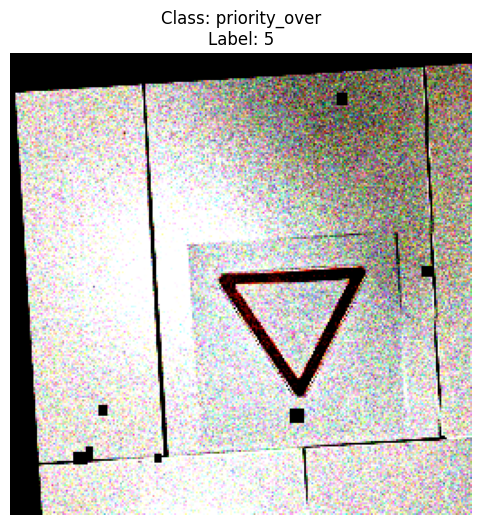

In [32]:
random_idx = random.randint(0, len(trafficSign)-1)
sign_sample(trafficSign, random_idx)